# Finite Impulse Response (FIR) Filter Design

This notebook shows how to design and find the frequency response of an FIR filter using the IDFT. The example filter designed here is a low pass filter with cutoff frequency, $f_c$. 

We would like to know the frequency response of this FIR filter having $N$ filter coefficients. In is designed by using the IDFT of the desired frequency response.  We know it is correct at the sample points, but what about other frequencies.  Maybe it is bouncing all over the place there.  This notebook describes a way to find this information using the computer.  There is an analytical way of finding it at every frequency too, but that requires a little more theoretical work to explain.

Pick $N$ to be odd.  Otherwise $H(-n) \ne H(n)^*$ and $h(k)$ will not be real.  $H(n) = H(n+N)$ is a sampled version of the desired frequency response.  It is sampled every $1/{NT}$ Hz for frequencies from $-1/{2T} < f < 1/{2T}$ to obtain $N$ points.  Then the negative frequency samples are moved ahead by one period, or $N$ points, so that, for example, $H(-1)$ is moved to $H(N-1)$, and $H(-2)$ is moved to $H(N-2)$.  This leaves us with $\{ H(0), H(1), ..., H(N-1)\}$.  We then use the IDFT to obtain the FIR filter coefficients.  $$h(k) = \sum_{n=0}^{N-1} H(n)e^{j2\pi nk/N}$$.  A python example is shown below.

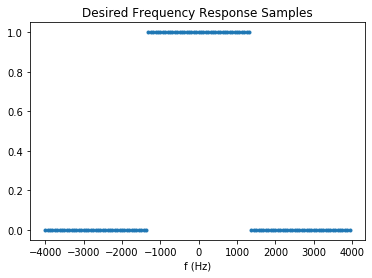

In [18]:
# Low Pass FIR Filter Design
import numpy as np
import matplotlib.pyplot as plt

T =  1/8000
N = 128  # Don't pick N odd.  If you do, H(-n) will not equal H(n)^*, and h(k) will not be real.
f_c = 1/6/T  # Cutoff of low pass filter

k = np.arange(0,N)
n = np.arange(np.int(-N/2),np.int((N+1)/2), 1)
f = n/N/T
H = np.piecewise(f, [(-f_c < f)&(f < f_c), (f >= f_c)|(f <= -f_c)],[1, 0])
plt.plot(f, H, '.')
plt.title('Desired Frequency Response Samples')
plt.xlabel('f (Hz)')
plt.show()

Notice that the desired frequency respones is only specified at the $N$ points as described above.

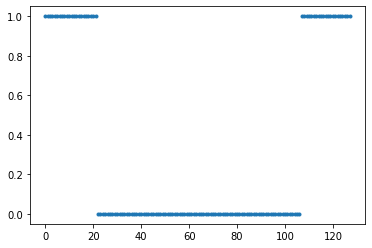

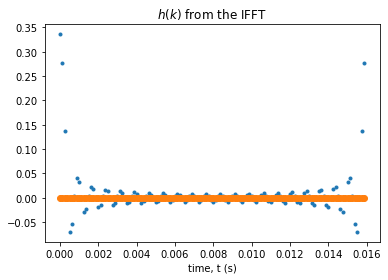

In [19]:
Hs = np.fft.fftshift(H)  # Now shift the frequency components for doing the IFFT.
plt.plot(k, Hs,'.')
plt.show()
h = np.fft.ifft(Hs)
t = k*T
plt.plot(t, np.real(h), '.', t, np.imag(h), 'o')
plt.xlabel('time, t (s)')
plt.title('$h(k)$ from the IFFT')
plt.show()

Notice that $h(k)$ as given above is large at first and at the end.  Remember that $h(k) = h(k+N)$.  If you really want to know what the impulse response looks like you need to shift the last half of the data back $N$ points.  This makes it evident that this filter is noncausal, because it's impulse response starts before the impulse occurs.  It is also important to make this shift if the data to be filtered is not periodic with period, $N$.

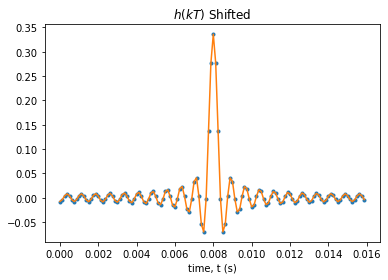

In [20]:
#h = np.fft.fftshift(h)  # Uncomment this line to see what happens
# when you don't shift, but use this to filter a signal x(t) with
# longer duration than NT.

hs = np.fft.fftshift(h)
plt.plot(t, hs, '.', t, hs)
plt.xlabel('time, t (s)')
plt.title('$h(kT)$ Shifted')
plt.show()

It really isn't possible to have a noncausal filter function such as the one you see above.  The solution is to delay it by $NT/2$.  This delays the output by the same amount, but at least you can do do the filtering.  With that delay, the index $k$, runs from zero to $N-1$ so that $0 \le k <N$.

Now we would like to view the frequency spectra at points in between the sampled points to see how it really looks.  To do this, recall that the spacing between FFT points is $1/{NT}$.  If we added a bunch of zeros before and after the impulse response above, and took the FFT, we would have more resolution.  The zeros basically are assuming that the impulse response before and after what you see above is zero, and that is actually exactly right, the way we are filtering the incoming A/D samples, $x(kt)$ where $k$ keeps advancing as long as the song lasts.

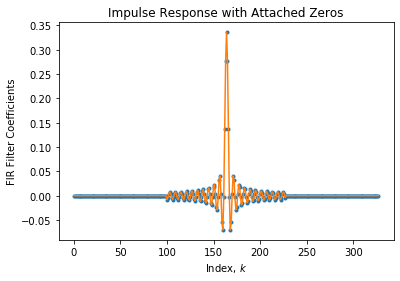

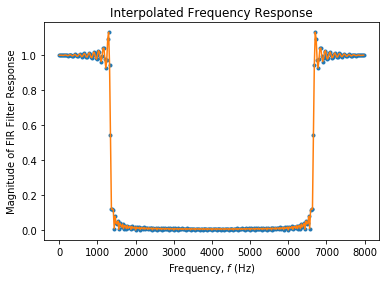

In [21]:
M = 100  # Half the number of zeros to add.
h_ext = np.concatenate((np.zeros(M), hs), 0)
h_ext = np.concatenate((h_ext, np.zeros(M)), 0)
plt.plot(h_ext,'.', h_ext)
plt.title('Impulse Response with Attached Zeros')
plt.xlabel('Index, $k$')
plt.ylabel('FIR Filter Coefficients')
plt.show()
H_interp = np.fft.fft(h_ext)

m = np.arange(0, 2*M+N)
f_interp = 1/(2*M+N)/T*m
#f_interp = np.arange(0, 1/T-1/(2*M+N)/T, 1/(2*M+N)/T)
H_interp_mag = np.abs(H_interp)
H_interp_angle = np.angle(H_interp)
plt.plot(f_interp, H_interp_mag,'.',f_interp, H_interp_mag)
plt.title('Interpolated Frequency Response')
plt.xlabel('Frequency, $f$ (Hz)')
plt.ylabel('Magnitude of FIR Filter Response')
plt.show()

Note that the frequencies $ 5 < f < 10 $ are really the negative frequency components, $-5 < f < 0$.  The periodic nature of the frequency response and the Gibbs phenomena (side lobes of the filter) are very evident.  If you plot the response in decibels, you get this.  Also note the sharp discontinuity just after the first set of zeros end, and just as the second set begins.  This causes the [Gibbs phenomenom](https://en.wikipedia.org/wiki/Gibbs_phenomenon) and the nasty sidelobes you can easily see in the decibel plot below.  The ultimate

Text(0, 0.5, 'Magnitude of FIR Filter Response (dB)')

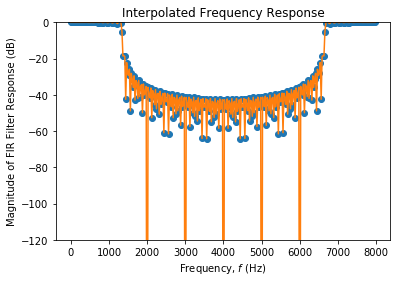

In [22]:
H_m_db = 20*np.log10(H_interp_mag)
plt.ylim([-120,0])
plt.plot(f_interp, H_m_db,'o',f_interp, H_m_db)
plt.title('Interpolated Frequency Response')
plt.xlabel('Frequency, $f$ (Hz)')
plt.ylabel('Magnitude of FIR Filter Response (dB)')

Another thing that would be instructive is to construct what happens if you didn't delay the impulse response by $NT/2$.  You can comment out a line of code above that does the fftshift and run the cells further down to see how terrible the result is. 
## Windowing
Note that the sidelobes of the filter above are really pretty big.  To take care of that you need to smooth out the transition at the end of the original filter coefficients.  This is done with a [windowing function](https://www.edn.com/electronics-news/4383713/Windowing-Functions-Improve-FFT-Results-Part-I).  This next section shows what can be accomplished with a Blackman window, one of my favorites.  A windowing function is a function whose purpose is the reduce the effect of the discontinuity at the point where the FIR filter stops, because more coefficients were all approximated to be zero.  Here is a plot of the Blackman window.  Notice how it gradually builds to one, and decays back to zero.

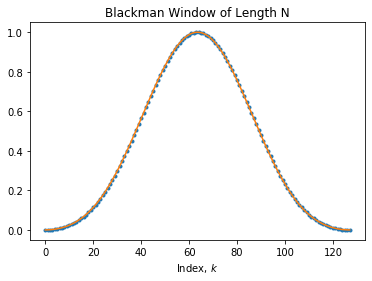

In [23]:
blackman = np.blackman(N)
plt.plot(blackman, '.', blackman)
plt.title('Blackman Window of Length N')
plt.xlabel('Index, $k$')
plt.show()

To apply the Blackman window we multiply the original filter by it, so the discontinuities are smoothed out.  Here is what the result looks like.

Text(0.5, 0, 'Index $k$')

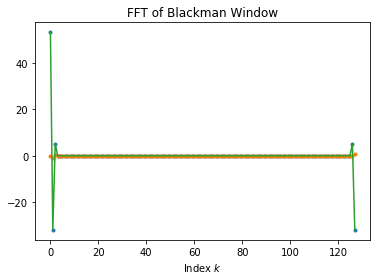

In [24]:
Blackman = np.fft.fft(blackman)
plt.plot(np.real(Blackman), '.', np.imag(Blackman), '.', Blackman)
plt.title('FFT of Blackman Window')
plt.xlabel('Index $k$')

Windowing in time is convolving in frequency.  The Blackman window is even in frequency.  When you convolve with it, the effect is to perform the weighted average, which ends up being over just several nearest neighbors.  This smooths out the frequency response.

Text(0.5, 0, 'Index, $k$')

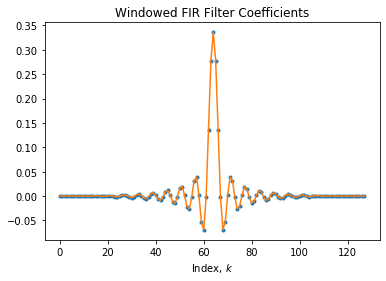

In [25]:
h_windowed = hs*blackman
plt.plot(h_windowed, '.', h_windowed)
plt.title('Windowed FIR Filter Coefficients')
plt.xlabel('Index, $k$')

Let's see how this helps the frequency response of our FIR filter.  We do the same interpolation done above, but with the windowed coefficients.

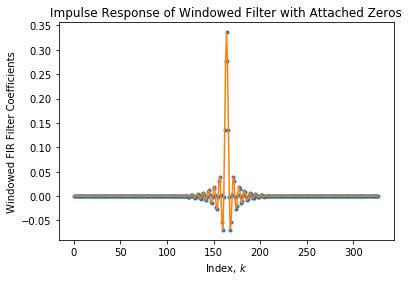

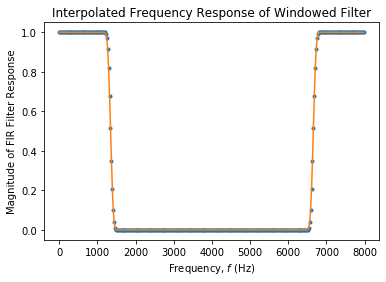

In [26]:
h_window_ext = np.concatenate((np.zeros(M), h_windowed), 0)
h_window_ext = np.concatenate((h_window_ext, np.zeros(M)), 0)
plt.plot(h_window_ext,'.', h_window_ext)
plt.title('Impulse Response of Windowed Filter with Attached Zeros')
plt.xlabel('Index, $k$')
plt.ylabel('Windowed FIR Filter Coefficients')
plt.show()
H_window_interp = np.fft.fft(h_window_ext)
H_window_interp_mag = np.abs(H_window_interp)
H_window_interp_angle = np.angle(H_window_interp)
plt.plot(f_interp, H_window_interp_mag,'.',f_interp, H_window_interp_mag)
plt.title('Interpolated Frequency Response of Windowed Filter')
plt.xlabel('Frequency, $f$ (Hz)')
plt.ylabel('Magnitude of FIR Filter Response')
plt.show()

Now let's compare the responses of the windowed and unwindowed in decibels.

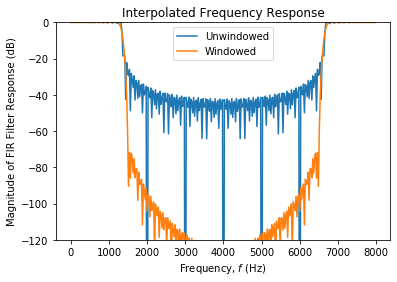

In [27]:
H_m_window_db = 20*np.log10(H_window_interp_mag)
plt.ylim([-120,0])
plt.plot(f_interp, H_m_db, f_interp, H_m_window_db)
plt.title('Interpolated Frequency Response')
plt.xlabel('Frequency, $f$ (Hz)')
plt.ylabel('Magnitude of FIR Filter Response (dB)')
plt.legend(['Unwindowed', 'Windowed'])

Notice that the windowed filter has much better ultimate attenuation in the stop band.  The cost is that it does not roll off quite as fast as the unwindowed filter.  The windowed filter is usually better to use in practice.